In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import glob

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = io*np.pi/180 #np.radians(io) #inclination #25.86
    pa = pa*np.pi/180 #np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def readmist(file):
    with open(file) as f:
        #lines = f.readlines()
        df = pd.read_csv(file,comment='#',names = ['EEP','log10_isochrone_age_yr','initial_mass',\
                                                   'star_mass','log_Teff','log_g','log_L','FeH_init',\
                                                   'FeH','Bessell_U','Bessell_B','Bessell_V','Bessell_R',\
                                                   'Bessell_I','2MASS_J','2MASS_H','2MASS_Ks','Kepler_Kp',\
                                                   'Kepler_D51','Hipparcos_Hp','Tycho_B','Tycho_V',\
                                                   'Gaia_G_DR2Rev','Gaia_BP_DR2Rev','Gaia_RP_DR2Rev',\
                                                   'Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW',\
                                                   'TESS','phase'],sep='\s+')
        table_out = Table.from_pandas(df)
    return table_out

def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
#########################
### Import fits files ###
#########################

#BaSTI
files = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.isc_2mass')

nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1])

for j in range(len(files)):
    tab = readbasti(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)
        
#create rgb only table
#rgb branch 489 to 1289 in each isochrone

out_rgb  = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat'
for i, fname in enumerate(datfiles):
    df2 = pd.read_csv(fname,names=nom)
    df2 = df2[489:1289]
    df2.to_csv(out_rgb, mode = 'a+', index= False, header = False)
    
# #Read in All dat file
# basti = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat')
# tbasti = Table.from_pandas(basti)

#Read in RGB dat file
nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']
bastiall = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat',names=nom)
tbastiall = Table.from_pandas(bastiall)
tempgravcut = np.where((tbastiall['LOGT']<=3.75)&(tbastiall['LOGG']<3.5))
basti = tbastiall[tempgravcut]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist.dr16beta.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' , 1)
clnpdfout = pdfout[clnr]

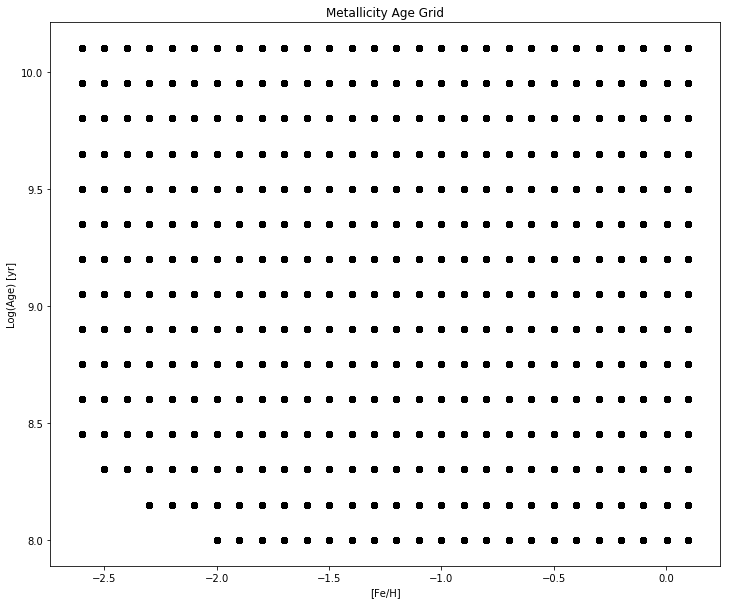

In [3]:
############################
### Metallicity Age Grid ###
############################

plt.figure(figsize=[12,10])
plt.scatter(basti['FEH'],basti['LOGAGE'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('BaSTIrgbgrid.pdf',bbox_inches='tight')
plt.show()

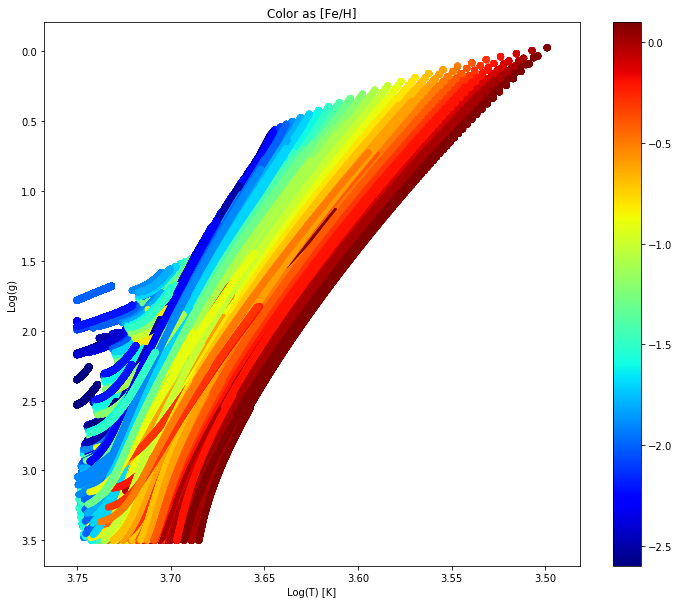

In [4]:
##################
### HR Diagram ###
##################

plt.figure(figsize=[12,10])
plt.scatter(basti['LOGT'],basti['LOGG'],c=basti['FEH'],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()

In [7]:
import itertools as it

y1 = basti['LOGT']
y2 = basti['KMAG']
y3 = basti['FEH']
y4 = basti['LOGG']
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

models = []
models_str = []
all_var_str = ['y1','y2','y3','y4','y12','y13','y14','y23','y24','y34','y1sq','y2sq','y3sq','y4sq']
all_var = [y1,y2,y3,y4,y12,y13,y14,y23,y24,y34,y1sq,y2sq,y3sq,y4sq]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2' and models_str[j][2]=='y3' and models_str[j][3]=='y4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str_good = np.array(models_str)[idx]

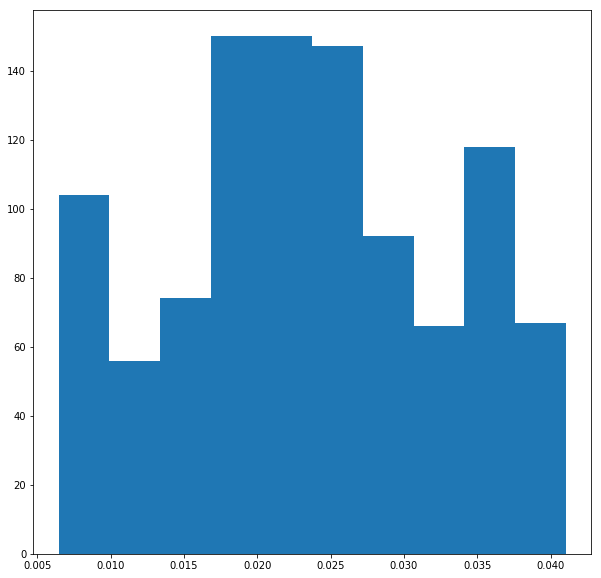

0.006447289220265162
[array(['y1', 'y2', 'y3', 'y4', 'y12', 'y13', 'y14', 'y23', 'y24', 'y34',
       'y2sq', 'y4sq'], dtype='<U4')]
[array([ 6.42380238e+01, -1.08151070e+01,  8.59231921e+00,  4.66376789e+00,
       -1.69156768e+01, -1.53285545e+00, -1.39531492e+00,  2.84760902e+00,
       -4.94895399e-02, -5.38414382e-01,  1.87880631e-01,  1.26030166e-01,
        5.56493236e-01])]


In [8]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(basti['LOGAGE'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - basti['LOGAGE']
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
plt.figure(figsize=[10,10])
plt.hist(model_mads)
plt.show()
    
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(models_str_good[best])
print(np.asarray(model_params)[best])

In [9]:
small = np.where(np.asarray(model_mads)<=0.01)

terms = []
for i in range(len(models_str_good[small])):
    terms.append(len(models_str_good[small][i]))
    
print(terms)
print(models_str_good[small][0])

parsimonious = np.array([y1,y2,y3,y4,y24,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(basti['LOGAGE'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - basti['LOGAGE']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

[8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14]
['y1' 'y2' 'y3' 'y4' 'y24' 'y2sq' 'y3sq' 'y4sq']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 6.604e+08
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:34:08   Log-Likelihood:             1.2206e+07
No. Observations:             4800675   AIC:            

In [10]:
##########################
### Define Model Above ###
##########################

def basfit(x1,x2,x3,x4):
    p = [13.03460029,  3.79689403,  3.32584733,  0.25049076, -7.74881108, -0.63878214,\
         0.13973642,  0.05510403,  0.7028039 ]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x2,x4)+p[6]*(x2**2)+p[7]*(x3**2)+p[8]*(x4**2)

In [11]:
######################
### Calculate Ages ###
######################

CM = clndr16['C_FE'] + clndr16['FE_H'] - clndr16['M_H']
NM = clndr16['N_FE'] + clndr16['FE_H'] - clndr16['M_H']
newalpha = np.log10(10**clndr16['ALPHA_M'] + 10**CM ) #+ 10**NM

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
basage = basfit(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],newalpha),clndr16['LOGG'])

In [12]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR): #,nfe,nfeERR
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    #aMnoise = np.random.normal(0, amERR) #[alpha/M]
    #cfenoise = np.random.normal(0, cfeERR) #[C/Fe]
    #nfenoise = np.random.normal(0, nfeERR) #[N/Fe]
    #fehnoise = np.random.normal(0, fehERR) #[Fe/H]
    
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    hxERR = 10**(am)*np.log(10)*amERR
    hyERR = 10**(CM)*np.log(10)*CMERR
    hzERR = 10**(NM)*np.log(10)*NMERR
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    alph = np.log10(10**am+10**cm+10**nm) #+10**nm
    alphERR = np.sqrt((hxERR)**2+(hyERR)**2+(hzERR)**2) #+(hzERR)**2
    
    alphanoise = np.random.normal(0, np.absolute(0.434*(alphERR/alph)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    aMnew = alph + ((-1)**np.random.randint(2))*alphanoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, aMnew, lggnew

In [13]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    am = clndr16['ALPHA_M'][i]
    amERR = clndr16['ALPHA_M_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nam,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(basfit(nlgT,nks,sal(nmh,nam),nlgg))
    
    devs.append(mad(ages))

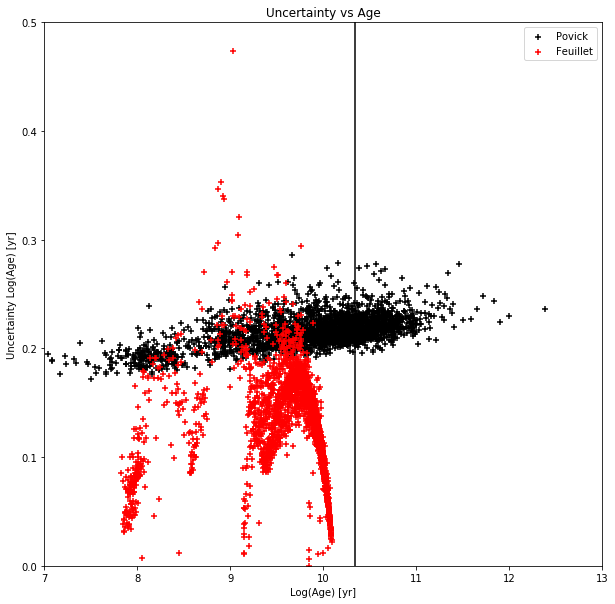

In [14]:
########################
### Uncertainty Plot ###
########################

plt.figure(figsize=[10,10])
plt.scatter(basage,devs,c='k',marker='+',label='Povick')
plt.scatter(clnpdfout['P_MEAN'],clnpdfout['P_VAR'],c='r',marker='+',label='Feuillet')
plt.xlim(7,13)
plt.axvline(10.13+np.mean(devs),c='k')
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty Log(Age) [yr]')
plt.ylim(0.0,0.5)
plt.title(r'Uncertainty vs Age')
plt.legend()
plt.show()

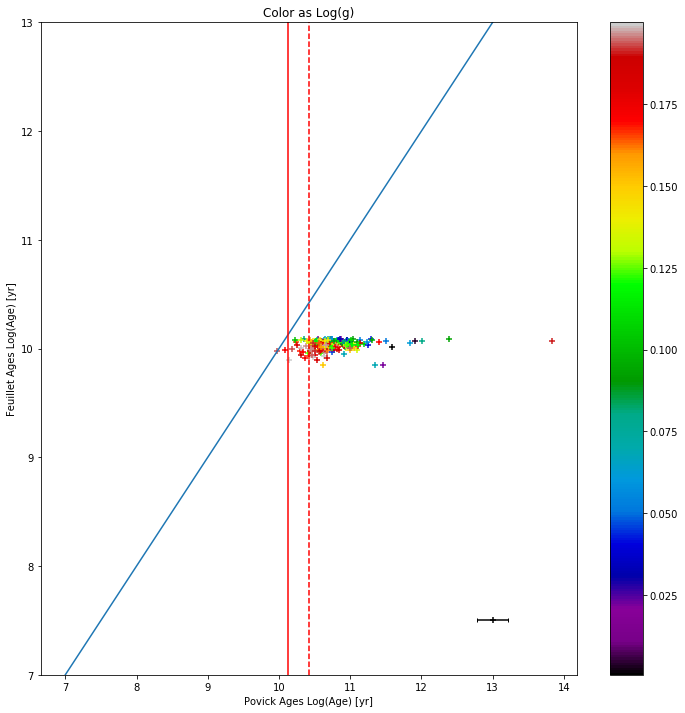

In [15]:
lowgrav = np.where(clndr16['LOGG']<0.20)
plt.figure(figsize=[12,12])
plt.scatter(basage[lowgrav],clnpdfout['P_MEAN'][lowgrav],c=clndr16['LOGG'][lowgrav],marker='+',\
            cmap='nipy_spectral')
# plt.scatter(parage,clnpdfout['P_MEAN'],c=clndr16['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:blue')
plt.ylim(7,13)
plt.scatter(13,7.5,c='k',marker='+')
plt.errorbar(13,7.5,xerr=np.mean(devs),c='k',capsize=2)
plt.axvline(10.13,c='r')
plt.axvline(10.13+max(devs),c='r',linestyle='--')
plt.xlabel(r'Povick Ages Log(Age) [yr]')
plt.ylabel(r'Feuillet Ages Log(Age) [yr]')
plt.title(r'Color as Log(g)')
#plt.savefig('nograv_age_age.pdf',bbox_inches='tight')
plt.show()

In [16]:
len(np.squeeze(lowgrav))/len(clndr16)

0.09796272214997832